# Part 4. Model Comparison

## Importing libraries and setting global variables

In [1]:
# Import usual library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling library
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

# Library to save the model
import pickle

## Importing datasets

In [2]:
def read_train_test(status='train'):
    # Function to select dataset to read
    if status == 'train':
        df = pd.read_csv('../datasets/train_cleaned.csv')
        df_discrete = pd.read_csv('../datasets/train_discrete_cleaned.csv')
        
    elif status == 'test':
        df = pd.read_csv('../datasets/test_cleaned.csv')
        df_discrete = 0
        
    else:
        print(f"Select the correct dataset")
        
    return df,df_discrete

In [3]:
# Select 'train' to read train.csv
# Select 'test' to read test.csv
df,df_discrete = read_train_test('train')

In [4]:
# View head
df.head(5)

,ms_zoning,lot_frontage,street,lot_shape,lot_contour,utilities,lot_config,lot_slope,neighborhood,condition_1,...,sale_price,has_2nd_floor_sf,total_sf,has_basement_sf,total_bath,has_open_porch,has_fireplace,has_wood_deck,log_sale_price,log_lot_area
0,Res,80.0,1,1,1,AllPub,Corner,1,SawyerW,N,...,159000,0,2436.0,1,1.5,1,0,0,11.976659,9.170039
1,Res,90.0,1,0,1,AllPub,CulDSac,1,SawyerW,N,...,271900,0,4354.0,1,2.0,1,1,1,12.513190,9.594514
2,Res,60.0,1,0,1,NoSeWa,CulDSac,1,Timber,N,...,137500,0,2163.0,1,1.5,1,1,0,11.831379,9.573246
3,Res,48.0,1,1,1,AllPub,Inside,1,NridgHt,N,...,248500,0,2907.0,1,2.0,1,1,1,12.423198,8.775240
4,Res,61.0,1,0,1,AllPub,Inside,1,Gilbert,R,...,167000,1,1758.0,1,2.5,0,0,0,12.025749,9.183380


# Run model to check numerical model

#### Create function to run linear regression

In [5]:
def linreg_log(X,y,t_s=0.2,log=False,name='log_model'):
    # model to train data - with selection of training with ln-y or y
    
    # train test split and instantiate
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=t_s,random_state=42)
    lr = LinearRegression()
    
    if log == True:
        # flow to train with ln-y
        
        # transform y to ln
        y_train_log = np.log(y_train)
        y_test_log = np.log(y_test)
        
        # fit model to ln(y)
        lr.fit(X_train,y_train_log)
        
        # predict train and test
        y_train_pred_log = lr.predict(X_train)
        y_test_pred_log = lr.predict(X_test)
        
        # exponential transform ln(y) back to y
        y_train_preds = np.exp(y_train_pred_log)
        y_test_preds = np.exp(y_test_pred_log)
        
        # print model name
        print()
        print(f" {name} ".center(30, "="))
        
        # train test R^2 scores
        train_r2 = lr.score(X_train,y_train_log)
        test_r2 = lr.score(X_test,y_test_log)

        # cross validation score
        mean_cross_val = cross_val_score(lr, X_train, y_train_log)
        
    else:
        
        # fit model to y
        lr.fit(X_train,y_train)
        
        # predict train and test y
        y_train_preds = lr.predict(X_train)
        y_test_preds = lr.predict(X_test)
        
        # print model name
        print()
        print(f" {name} ".center(30, "="))
        
        # train test score
        train_r2 = lr.score(X_train,y_train)
        test_r2 = lr.score(X_test,y_test)

        # cross validation score
        mean_cross_val = cross_val_score(lr, X_train, y_train)

    # metrics (comparing y_preds with y)
    rmse_train = round(metrics.mean_squared_error(y_train,y_train_preds,squared=False),2)
    rmse_test = round(metrics.mean_squared_error(y_test,y_test_preds,squared=False),2)
    
    # print model scores
    print()
    print(f"train r2: {train_r2.round(4)}")
    print(f"test_r2: {test_r2.round(4)}")
    print(f"mean cross val: {mean_cross_val.round(4)}")
    print(f"train rmse: {rmse_train}")
    print(f"test rmse: {rmse_test}")
    
    # create plots of predictions vs true values - to help visualize model performance
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    
    # correlation calculation
    cor = np.corrcoef(y_test,y_test_preds)
    
    # scatter plot (left) of y_test vs y_test_preds
    plot1 = sns.scatterplot(ax=axes[0],x=y_test,y=y_test_preds)
    sns.lineplot(ax=axes[0],x=y_test,y=y_test)
    plot1.set_xlabel('y_test')
    plot1.set_ylabel('y_test_preds')
    plot1.set_title(f"y_test vs y_test_preds (corr: {cor[0][1].round(4)})")
    
    # histogram (right) of y_test vs y_test_preds
    plot2 = sns.histplot(ax=axes[1],x=y_test,color='grey',alpha=0.5)
    plot2 = sns.histplot(ax=axes[1],x=y_test_preds)
    plot2.set_xlabel('log_sale_price')
    plot2.set_title(f"y_test vs y_test_preds - Histogram");
    
    return y_test,y_test_preds

In [6]:
# Count total numbers of numerical columns
print(f" Our dataset has {len(df.select_dtypes(exclude=object).columns)-2} numeric columns")

 Our dataset has 25 numeric columns


### Model Tuning 1: Numerical only (Top 15 correlated features)

In [7]:
# Selecting top 15 correlated features from numeric columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)[:17]

In [8]:
# Selecting X and y from the dataset
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


====== Top 15 Features =======

train r2: 0.8938
test_r2: 0.8856
mean cross val: [0.9034 0.8756 0.8806 0.9048 0.8855]
train rmse: 22933.95
test rmse: 23948.34


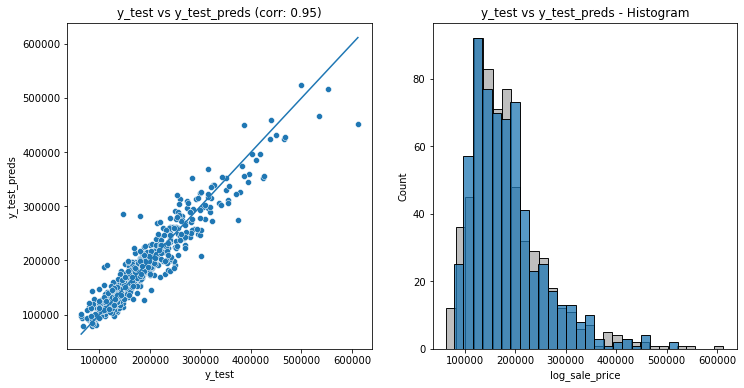

In [9]:
# running the first iteration 
y_test,y_test_preds = linreg_log(X,y,0.3,True,name='Top 15 Features')

----

### Model Tuning 2: Numerical only (Top 20 correlated features)

In [10]:
# Selecting top 20 correlated (to log_sale_price) numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)[:22]

In [11]:
# Training
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


====== Top 20 Features =======

train r2: 0.8968
test_r2: 0.8924
mean cross val: [0.9038 0.8707 0.8845 0.9042 0.8903]
train rmse: 22683.42
test rmse: 23544.95


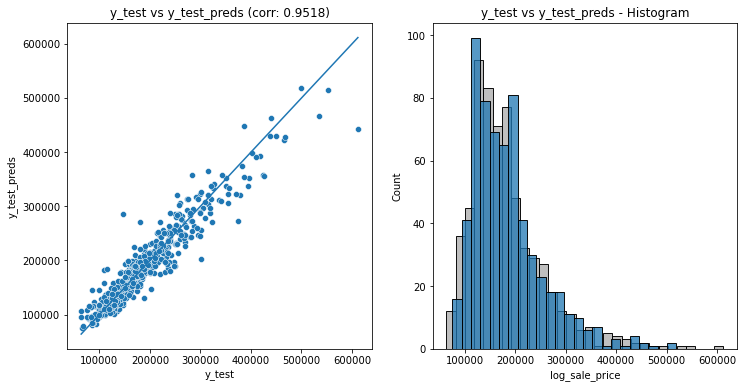

In [12]:
# running 2nd iteration
y_test,y_test_preds = linreg_log(X,y,0.3,True,name='Top 20 Features')

----

### Model Tuning 3: Numerical only (All 25 features)

In [13]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [14]:
# Training
X = df[num_cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']


====== All 25 Features =======

train r2: 0.9158
test_r2: 0.9127
mean cross val: [0.9233 0.8924 0.9016 0.9227 0.9059]
train rmse: 20912.15
test rmse: 22084.26


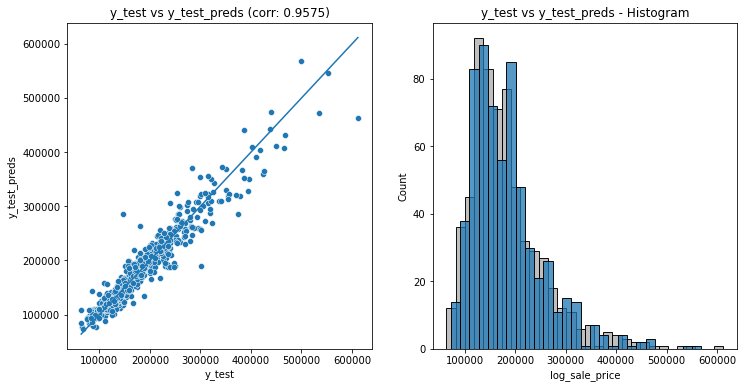

In [15]:
# running the model
y_test,y_test_preds = linreg_log(X,y,0.3,True, name='All 25 Features')

----

### Model Tuning 4: Numerical + Categorical (3 Quality - external/heating/kitchen)

In [16]:
# Select quality related columns - try to reduce number of categorical
# Selecting three with more evenly distributied category couts 
# and variation in sale_price per category
cat_cols = ['external_quality','heating_quality','kitchen_quality']

In [17]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [18]:
# Combine columns
cols = num_cols + cat_cols

In [19]:
# Training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [20]:
# Get dummies
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


 All 25 Features + 3 Qualities 

train r2: 0.9202
test_r2: 0.9157
mean cross val: [0.9276 0.8954 0.9029 0.9266 0.908 ]
train rmse: 20124.5
test rmse: 21364.37


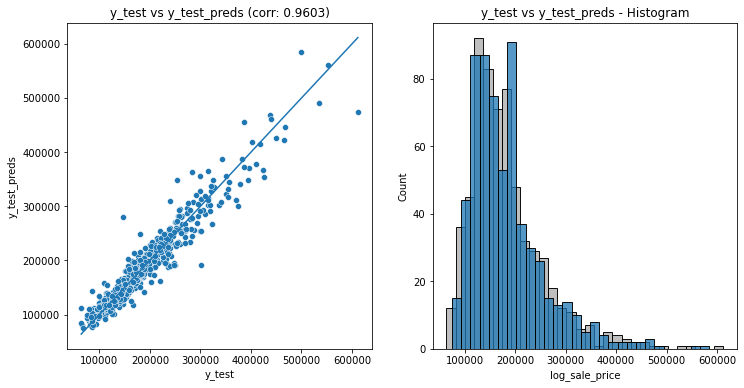

In [21]:
# Run the model
y_test,y_test_preds = linreg_log(X,y,0.3,True,name='All 25 Features + 3 Qualities')

---

### Model Tuning 5: Numerical + Categorical (Quality Related Columns)

In [22]:
# Select all quality related categorical columns
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality']

In [23]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [24]:
# Combine columns
cols = num_cols + cat_cols

In [25]:
# Selecting X and y for model training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [26]:
# Get dummies for categorical columns
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


= All 25 Features + Quality ==

train r2: 0.9226
test_r2: 0.9167
mean cross val: [0.9299 0.8952 0.9033 0.925  0.9095]
train rmse: 19704.42
test rmse: 21084.5


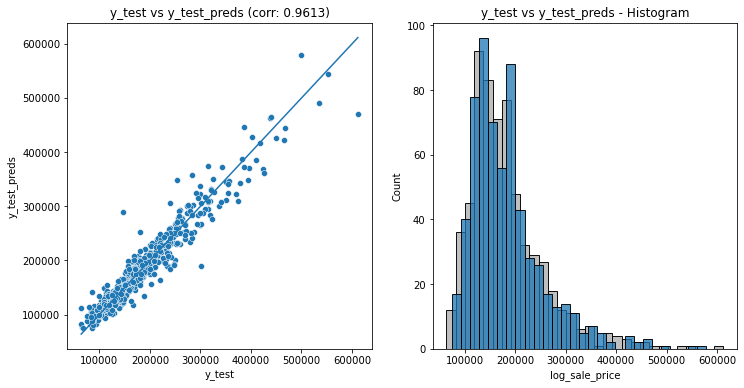

In [27]:
# Testing the model
y_test,y_test_preds = linreg_log(X,y,0.3,True,name='All 25 Features + Quality')

----

### Model Tuning 6: Numerical + Categorical (All quality + Other evenly distributed category)

In [28]:
df.select_dtypes(include=object).columns

Index(['ms_zoning', 'utilities', 'lot_config', 'neighborhood', 'condition_1',
       'condition_2', 'building_type', 'house_style', 'roof_style',
       'roof_material', 'exterior_1', 'exterior_2', 'masonry_type',
       'external_quality', 'external_condition', 'foundation',
       'basement_quality', 'basement_condition', 'basement_exposure',
       'basement_fin_type_1', 'basement_fin_type_2', 'heating',
       'heating_quality', 'electrical', 'kitchen_quality', 'fireplace_quality',
       'garage_type', 'garage_fin', 'garage_quality', 'garage_condition',
       'paved_drive', 'sale_type', 'sale_condition'],
      dtype='object')

In [29]:
# Select quality related columns - try to reduce number of categorical
# Selecting three with more evenly distributied category couts 
# and variation in sale_price per category
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality','garage_fin','building_type','house_style','sale_type','sale_condition',
            'condition_1','masonry_type','roof_style']

In [30]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [31]:
# Combine columns
cols = num_cols + cat_cols

Split the data

In [32]:
# Training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [33]:
# Get dummies
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


 All 25 Features + Categories 

train r2: 0.9306
test_r2: 0.9145
mean cross val: [0.9331 0.9112 0.9075 0.9286 0.9157]
train rmse: 18886.56
test rmse: 21113.81


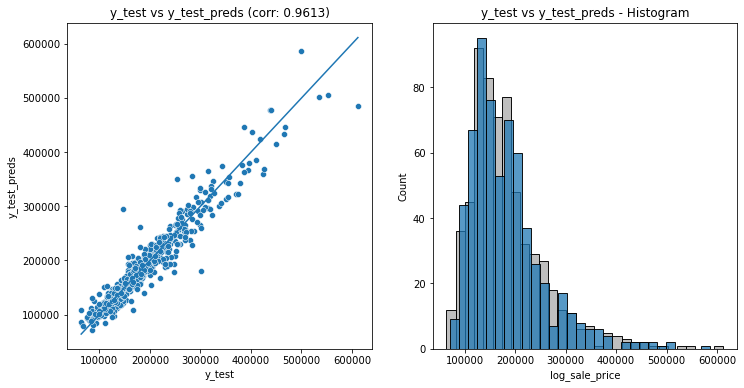

In [34]:
# Run the model
y_test,y_test_preds = linreg_log(X,y,0.3,True,name='All 25 Features + Categories')

---

#### Model Tuning 7: Numerical + Categorical (All quality + Discrete Converted Columns)

In [35]:
# Select quality related columns - try to reduce number of categorical
# Selecting three with more evenly distributied category couts 
# and variation in sale_price per category
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality','total_rooms_above_ground','garage_cars','total_bath']

In [36]:
# Selecting all numerical columns
num_cols = list(df_discrete.corr()['log_sale_price'].sort_values(ascending=False).index)

In [37]:
# Combine columns
cols = num_cols + cat_cols

Split the data

In [38]:
# Training
X = df_discrete[cols].drop(columns=['sale_price','log_sale_price'])
y = df_discrete['sale_price']

In [39]:
# Get dummies
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)


 All Features + Quality + Discrete 

train r2: 0.9111
test_r2: 0.9001
mean cross val: [0.8963 0.9105 0.9083 0.9077 0.8915]
train rmse: 21800.42
test rmse: 22912.57


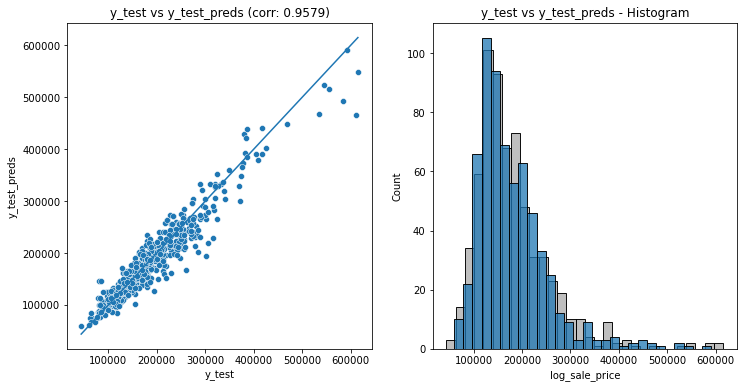

In [40]:
# Run the model
y_test,y_test_preds = linreg_log(X,y,0.3,True,name='All Features + Quality + Discrete')

---

## Fit the selected model again to save - Kaggle Competition Model

In [41]:
# Select all quality related categorical columns
cat_cols = ['external_quality','basement_quality','heating_quality','kitchen_quality','fireplace_quality',
           'garage_quality','garage_fin','building_type','house_style','sale_type','sale_condition',
            'condition_1','masonry_type','roof_style']

In [42]:
# Selecting all numerical columns
num_cols = list(df.corr()['log_sale_price'].sort_values(ascending=False).index)

In [43]:
# displaying columns to copy to test.csv
print(num_cols)

['log_sale_price', 'sale_price', 'overall_quality', 'total_sf', 'garage_cars', 'total_bath', 'year_built', 'has_fireplace', 'total_rooms_above_ground', 'has_open_porch', 'masonry_area', 'log_lot_area', 'lot_frontage', 'has_wood_deck', 'central_air', 'has_basement_sf', 'bedroom_above_ground', 'functional', 'street', 'has_2nd_floor_sf', 'month_sold', 'year_sold', 'lot_contour', 'lot_slope', 'overall_condition', 'kitchen_above_ground', 'lot_shape']


In [44]:
# Combine columns
cols = num_cols + cat_cols

In [45]:
# Selecting X and y for model training
X = df[cols].drop(columns=['sale_price','log_sale_price'])
y = df['sale_price']

In [46]:
# Get dummies for categorical columns
X = pd.get_dummies(columns=list(X.select_dtypes(include='object').columns), data = X, drop_first=True)

In [47]:
# Instantiate and fit
lr = LinearRegression()
y_log = np.log(y)

# fit model to ln(y)
model = lr.fit(X,y_log)

# save the model
filename = '../model/all_num_10_cat.sav'
pickle.dump(model, open(filename, 'wb'))